In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast
import re

In [33]:
# reading datasets
pos_df = pd.read_csv(r'C:\Users\Roydon\Desktop\it1244-final-project\data\pos.csv', index_col=0)
pos_df = pos_df.drop(columns=['FileName'])

neg_df = pd.read_csv(r'C:\Users\Roydon\Desktop\it1244-final-project\data\neg.csv', index_col=0)
neg_df = neg_df.drop(columns=['FileName'])

# Bring all positive rating values down to range of 5-8 (to ensure continuous range of ratings)
pos_df['rating'] = pos_df['rating'] - 2

# Merging data into one dataset
data = pd.concat([pos_df, neg_df], ignore_index=True)

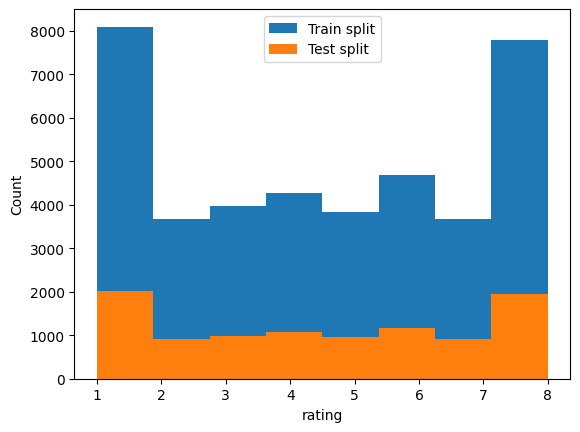

In [34]:
from sklearn.model_selection import train_test_split

X = data['Content']
y = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200, stratify=y)
train_split = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], ignore_index=True, axis=1)
train_split = train_split.rename(columns={0: 'Content', 1: 'rating'}) 

test_split = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], ignore_index=True, axis=1)
test_split = test_split.rename(columns={0: 'Content', 1: 'rating'}) 

plt.hist(train_split['rating'], bins=8)
plt.hist(test_split['rating'], bins=8)
plt.xlabel('rating')
plt.ylabel('Count')
plt.legend(['Train split', 'Test split'])

In [35]:
train_split.to_csv('train.csv')
test_split.to_csv('test.csv')

In [18]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
class CustomDataset(Dataset):
    ''' Custom dataset class defined to create '''

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Content = dataframe.Content
        self.targets = self.data.list
        self.max_len = max_len

    # __len__ and __getitem__ methods to create map-style dataset to be interfaced by torch DataLoader method
    def __len__(self):
        return len(self.Content)

    def __getitem__(self, index):
        # Data preprocessing code to convert to lower-cased, remove trailing whitespace, html tags and urls
        Content = str(self.Content[index]).lower()
        Content = re.sub(r'<[^>]+>', '', Content)  
        Content = re.sub(r'https://\S+|www\.\S+', '', Content)
        Content = " ".join(Content.split())

        # Tokenisation of text
        inputs = self.tokenizer.encode_plus(
            Content,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }